# MountainCar


In [1]:
import gym
import random
import numpy as np
import pandas as pd
from pylab import plt
from IPython import display
plt.style.use('seaborn-v0_8')
np.random.seed(100)
import warnings; warnings.simplefilter('ignore')

import tensorflow.compat.v1 as tf
from keras. layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
tf.random.set_random_seed(100)
tf.logging.set_verbosity(tf.logging.ERROR)

2024-05-30 03:36:49.182822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Environment

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

# Action Space

In [3]:
# Type of action space
env.action_space

# From github.com/openai/gym/wiki/MountainCar-vO, we see that
# 0 = push left, 1 = no push, 2 = push right

Discrete(3)

In [4]:
# Number of discrete actions
env.action_space.n

3

In [5]:
# Sample actions
[env.action_space.sample() for _ in range(10)]

[0, 0, 0, 0, 1, 2, 1, 2, 1, 1]

# Observation Space

In [6]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [7]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)

In [8]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

In [9]:
env.reset()
# [position, velocity]

(array([-0.41711023,  0.        ], dtype=float32), {})

# Visualisation

# Demonstrating that a simple strategy of a constant action choice does not solve the problem

The obvious/naive thing to do is to simply try to drive the car to the right. However, in doing so we find that the car cannot generate enough momentum to overcome the downward gravitational force.

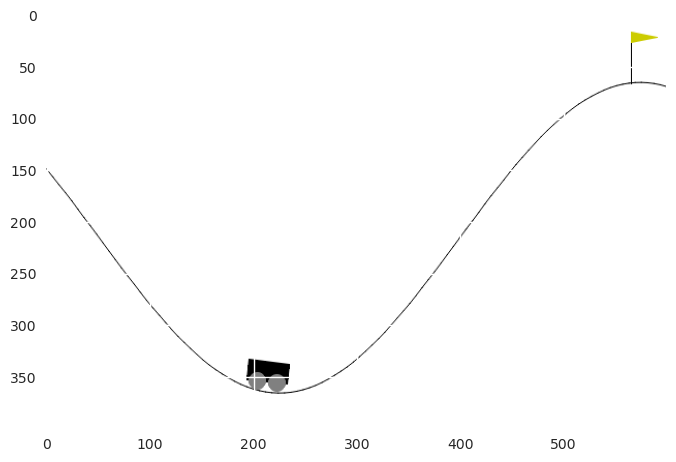

In [10]:
env.reset ()
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (151):
  img. set_data(env.render()) # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  a = env.action_space.sample() # random action choice
  a = 2 # constant action choice
  obs, rew, done, _, _ = env.step(a) # taking action
  if done and (e + 1) < 200:
    print('*** FAILED ***')
    break

# Setting Seeds

In [11]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_random_seed(seed)
    # env.seed(seed)

set_seeds()

# Q Learning

Notice that the `DQNAgent` class is largely the same as for the CartPole example, except in the learn method, in which a more specific reward scheme is designed. 

In [22]:
from collections import deque

class DQNAgent:
  def __init__(self):
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.gamma = 0.95
    self.batch_size = 128
    self.max_treward = -1e6
    self.averages = list()
    self.memory = deque(maxlen=2000)
    self.osn = env.observation_space.shape[0]
    self.model = self.create_model()

  def create_model(self):
    model = Sequential()
    model.add(Dense(128, input_dim=self.osn, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return env.action_space.sample()
    action = self.model.predict(state, verbose=0)
    return np.argmax(action)
  
  def replay(self):
    batch = random.sample(self.memory, self.batch_size)
    for state, action, reward, next_state, done in batch:
      # Reward design
      position = state[0,0]
      reward_ = position + 0.5
      if position >= self.max_position:
        self.max_position = position
        reward_ += 1
        if self.max_position > self.max_pos:
          self.max_pos = self.max_position
      if position > 0.5:
        reward_ += 100
      # Q-learning
      if not done:
        reward_ += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
      target = self.model.predict(state, verbose=0)
      target[0, action] = reward
      self.model.fit(state, target, epochs=1, verbose=False)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  def learn(self, episodes):
    trewards = []
    self.positions = []
    self.max_pos = -0.4
    for e in range(1,episodes+1):
      print(f"{e=}")
      state = env.reset()[0]
      state = np.reshape(state, [1, self.osn])
      treward = 0
      self.max_position = -0.4
      for time in range(5000):
        action = self.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.reshape(next_state, [1, self.osn])
        self.memory.append((state, action, reward, next_state, done))
        state = next_state
        treward += float(reward)
        position = state[0,0]
        # print(f"{done=}")
        if done or truncated or position >= 0.5:
          trewards.append(treward)
          self.positions.append(position)
          av = sum(trewards[:25]) / 25 # Work out a Rolling average
          self.averages.append(av)
          self.max_treward = max(self.max_treward, treward)
          print('Episode: {}/{}, treward: {}, av: {:.2}, max_r: {:2}, max_p: {}, pos: {}'.format(e, episodes, treward, av, self.max_treward, self.max_pos, position))          
          break
      if len(self.memory) > self.batch_size:
        self.replay()
      if position >= 0.5:
        break

  def test(self, episodes=100):
    rewards = []
    positions = []
    for e in range(1, episodes+1):
      print(f"{e=}")
      state = env.reset()[0]
      treward = 0
      for time in range(5000):
        state = np.reshape(state, [1, self.osn])
        action = np.argmax(self.model.predict(state, verbose=0)[0])
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        treward += reward
        if done or truncated or state[0] >= 0.5:
          rewards.append(treward)
          positions.append(state[0])
          print('Episode: {}/{}, treward: {}, position: {}'.format(e, episodes, treward, state[0]))
          break
    return rewards, positions

agent = DQNAgent()

In [23]:
%time agent.learn(750)

e=1
Episode: 1/750, treward: -200.0, av: -8.0, max_r: -200.0, max_p: -0.4, pos: -0.5057294368743896


e=2
Episode: 2/750, treward: -200.0, av: -1.6e+01, max_r: -200.0, max_p: -0.4, pos: -0.48974892497062683
e=3
Episode: 3/750, treward: -200.0, av: -2.4e+01, max_r: -200.0, max_p: -0.3823918104171753, pos: -0.5397820472717285
e=4
Episode: 4/750, treward: -200.0, av: -3.2e+01, max_r: -200.0, max_p: -0.3332175016403198, pos: -0.5588782429695129
e=5
Episode: 5/750, treward: -200.0, av: -4e+01, max_r: -200.0, max_p: -0.33295461535453796, pos: -0.549675464630127
e=6
Episode: 6/750, treward: -200.0, av: -4.8e+01, max_r: -200.0, max_p: -0.33295461535453796, pos: -0.6860173344612122
e=7
Episode: 7/750, treward: -200.0, av: -5.6e+01, max_r: -200.0, max_p: -0.3123317360877991, pos: -0.4807070791721344
e=8
Episode: 8/750, treward: -200.0, av: -6.4e+01, max_r: -200.0, max_p: -0.3123317360877991, pos: -0.6061118245124817
e=9
Episode: 9/750, treward: -200.0, av: -7.2e+01, max_r: -200.0, max_p: -0.3109513521194458, pos: -0.6046019196510315
e=10
Episode: 10/750, treward: -200.0, av: -8e+01, max_r: -200.

In [17]:
agent.epsilon

0.960693043575437

In [18]:
agent.max_pos

0.4130819

In [19]:
plt.figure(figsize=(10, 6))
agent.positions
# x = range(len(agent.positions))
# y = np.polyval(np.polyfit(x, agent.positions, deg=3), x)
# plt.plot(agent.positions, label='final position')
# plt.plot(x, y, 'r-', label='regression')
# plt.xlabel('episodes')
# plt.ylabel('position value')
# plt. legend()

[0.5011118]

<Figure size 1000x600 with 0 Axes>

# Testing the Agent

In [ ]:
trewards, tpositions = agent.test(100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
env.seed(140)
state = env.reset()
img = plt.imshow(env.render()) # initialize bitmap embedding
for e in range (201):
  img.set_data(env.render()) # updating the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state = np.reshape(state, [1, agent.osn] )
  a = np.argmax(agent.model.predict(state, verbose=0))  # learned action
  state, reward, done, truncate, info = env.step(a)
  if done and (e + 1) < 200:
    print(f'*** SUCCESS {e} ***')
    break
  elif done:
    print('*** FAILED ***')
    break